# Challenge: Model Comparison

Here let's work on regression. Find a data set and build a KNN Regression and an OLS regression. Compare the two. How similar are they? Do they miss in different ways?

Create a Jupyter notebook with your models. At the end in a markdown cell write a few paragraphs to describe the models' behaviors and why you favor one model or the other. Try to determine whether there is a situation where you would change your mind, or whether one is unambiguously better than the other. Lastly, try to note what it is about the data that causes the better model to outperform the weaker model. Submit a link to your notebook below.

## Job satisfaction of data scientist

Using Kaggle survey data on data scientist this notebook investigates the ability of OLS and kNN regression in predicting self-reported job satisfaction.

To keep models equivalent the same features are used in both cases (restricted to continuous variables).

### The data

Available from [here](https://www.kaggle.com/datasets)

Kaggle conducted an industry-wide survey to establish a comprehensive view of the state of data science and machine learning. The survey received over 16,000 responses and we learned a ton about who is working with data, what’s happening at the cutting edge of machine learning across industries, and how new data scientists can best break into the field.

In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection 
%matplotlib inline

In [234]:
# Loading the data
# Loading data from csv gave UnicodeError, but not from Excel?
fullsurvey = pd.read_excel('multipleChoice.xlsx')
fullsurvey.head()

,GenderSelect,Country,Age,EmploymentStatus,StudentStatus,LearningDataScience,CodeWriter,CareerSwitcher,CurrentJobTitleSelect,TitleFit,...,JobFactorExperienceLevel,JobFactorDepartment,JobFactorTitle,JobFactorCompanyFunding,JobFactorImpact,JobFactorRemote,JobFactorIndustry,JobFactorLeaderReputation,JobFactorDiversity,JobFactorPublishingOpportunity
0,"Non-binary, genderqueer, or gender non-conforming",NaN,NaN,Employed full-time,NaN,NaN,Yes,NaN,DBA/Database Engineer,Fine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Female,United States,30.0,"Not employed, but looking for work",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somewhat important,NaN,NaN
2,Male,Canada,28.0,"Not employed, but looking for work",NaN,NaN,NaN,NaN,NaN,NaN,...,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important
3,Male,United States,56.0,"Independent contractor, freelancer, or self-em...",NaN,NaN,Yes,NaN,Operations Research Practitioner,Poorly,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Male,Taiwan,38.0,Employed full-time,NaN,NaN,Yes,NaN,Computer Scientist,Fine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [235]:
print(fullsurvey.info(), '\n')

# Keeping only the variables of interest
survey = fullsurvey.loc[:, ['JobSatisfaction', 'Age', 'LearningCategorySelftTaught', 
                            'LearningCategoryOnlineCourses', 'LearningCategoryWork',
                            'LearningCategoryUniversity', 'LearningCategoryKaggle',
                            'LearningCategoryOther', 'TimeGatheringData',
                            'TimeModelBuilding', 'TimeProduction', 'TimeVisualizing',
                            'TimeFindingInsights', 'TimeOtherSelect', 'CompensationAmount', 'CompensationCurrency']]

print(survey.info())

# Cleaning JobSatisfaction
survey['JobSatisfaction'].replace('10 - Highly Satisfied', 10, inplace=True)
survey['JobSatisfaction'].replace('1 - Highly Dissatisfied', 1, inplace=True)
survey['JobSatisfaction'].replace('I prefer not to share', np.nan, inplace=True)

# Cleaning CompensationAmount: Change to numeric, drop if NaN
survey['CompensationAmount'] = pd.to_numeric(survey['CompensationAmount'], errors='coerce')

# Cleaning CompensationAmount: Getting rid of negative amounts, errors
# Cleaning CompensationAmount: Drop amounts considered too small (less than 10000 in any currency)
survey['CompensationAmount'] = survey['CompensationAmount'].where(survey['CompensationAmount']>10000, np.nan)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16716 entries, 0 to 16715
Columns: 228 entries, GenderSelect to JobFactorPublishingOpportunity
dtypes: float64(13), object(215)
memory usage: 29.1+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16716 entries, 0 to 16715
Data columns (total 16 columns):
JobSatisfaction                  6677 non-null object
Age                              16385 non-null float64
LearningCategorySelftTaught      13109 non-null float64
LearningCategoryOnlineCourses    13126 non-null float64
LearningCategoryWork             13111 non-null float64
LearningCategoryUniversity       13122 non-null float64
LearningCategoryKaggle           13126 non-null float64
LearningCategoryOther            13094 non-null float64
TimeGatheringData                7530 non-null float64
TimeModelBuilding                7528 non-null float64
TimeProduction                   7517 non-null float64
TimeVisualizing                  7529 non-null float64
TimeFindingInsigh

This dataset has a lot of missing values. Here, I drop all NaN in the variables I'm interested in. This might bias the sample in several ways:
- If unsatisfied workers are more likely to skip the question (sample skewed to higher happiness levels). However, the sample also contains students, unemployed, and self-employed who correctly skip the question.
- If not answering learning, or how time is spent at work, is affected by low satisfaction levels (although a counter argument is that more satisfied workers skip these questions as they actually want to get to their work)
- Income earned: Generally surveys struggle with reporting from high earners. But this is likely to be less of a problem here (not asking wealth questions, only salaray). For self-employed workers there may be under-reporting.
- The income earned variable has potential to be a noisy variable, it is in multiple curriencies, and some people may report in thousands, report net vs gross, or report monthly vs annual.


746


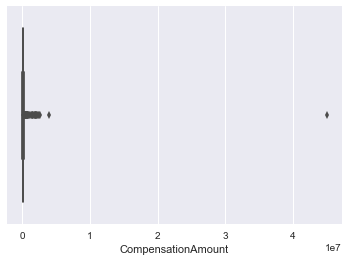

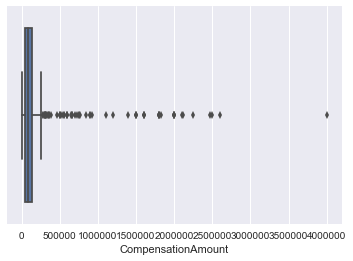

In [236]:
# Drop all NaN
survey.dropna(inplace=True, subset=['JobSatisfaction', 'Age', 'LearningCategorySelftTaught',
             'LearningCategoryOnlineCourses', 'LearningCategoryWork',
             'LearningCategoryUniversity', 'LearningCategoryKaggle',
             'LearningCategoryOther', 
             'TimeGatheringData', 'TimeModelBuilding', 'TimeProduction','TimeVisualizing',
             'TimeFindingInsights', 'TimeOtherSelect', 'CompensationAmount'])

# Check how many of CompensationAmount is unspecified in terms of currency
print(survey.CompensationCurrency.isnull().sum())

# One outlier at 45,000,000 (of some unknown currency)
sns.boxplot(survey.loc[survey.CompensationCurrency.isnull(), 'CompensationAmount'])
plt.show()

incomeoutlier = survey.loc[survey.CompensationCurrency.isnull(), 'CompensationAmount'].max()
survey = survey.loc[survey['CompensationAmount'] != incomeoutlier, :]

sns.boxplot(survey.loc[survey.CompensationCurrency.isnull(), 'CompensationAmount'])
plt.show()

# Assume the rest of the unknown currencies are in USD
survey.CompensationCurrency.fillna('USD', inplace=True)

In [237]:
# Number of observations left
survey.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4771 entries, 3 to 16673
Data columns (total 16 columns):
JobSatisfaction                  4771 non-null float64
Age                              4771 non-null float64
LearningCategorySelftTaught      4771 non-null float64
LearningCategoryOnlineCourses    4771 non-null float64
LearningCategoryWork             4771 non-null float64
LearningCategoryUniversity       4771 non-null float64
LearningCategoryKaggle           4771 non-null float64
LearningCategoryOther            4771 non-null float64
TimeGatheringData                4771 non-null float64
TimeModelBuilding                4771 non-null float64
TimeProduction                   4771 non-null float64
TimeVisualizing                  4771 non-null float64
TimeFindingInsights              4771 non-null float64
TimeOtherSelect                  4771 non-null float64
CompensationAmount               4771 non-null float64
CompensationCurrency             4771 non-null object
dtypes: float

In [238]:
# Why would 3 be to 16700?
survey.describe()

,JobSatisfaction,Age,LearningCategorySelftTaught,LearningCategoryOnlineCourses,LearningCategoryWork,LearningCategoryUniversity,LearningCategoryKaggle,LearningCategoryOther,TimeGatheringData,TimeModelBuilding,TimeProduction,TimeVisualizing,TimeFindingInsights,TimeOtherSelect,CompensationAmount
count,4771.000000,4771.000000,4771.000000,4771.000000,4771.000000,4771.000000,4771.000000,4771.000000,4771.000000,4771.000000,4771.000000,4771.000000,4771.000000,4771.000000,4.771000e+03
mean,6.747432,34.178369,33.271222,23.111402,20.284399,16.600189,5.277112,1.455677,37.414169,20.962377,10.960281,14.223748,13.657409,2.272270,2.372238e+07
std,2.145184,9.437994,24.577928,23.352728,19.774174,22.139384,10.273300,7.802879,20.792635,15.130699,12.058985,11.067081,12.290916,11.410166,1.448079e+09
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.040000e+04
25%,6.000000,27.000000,15.000000,5.000000,0.000000,0.000000,0.000000,0.000000,20.000000,10.000000,0.000000,10.000000,5.000000,0.000000,5.300000e+04
50%,7.000000,32.000000,30.000000,20.000000,20.000000,5.000000,0.000000,0.000000,40.000000,20.000000,10.000000,10.000000,10.000000,0.000000,1.000000e+05
75%,8.000000,39.000000,50.000000,30.000000,30.000000,30.000000,10.000000,0.000000,50.000000,30.000000,15.000000,20.000000,20.000000,0.000000,2.000000e+05
max,10.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000e+11


6.747432404108153


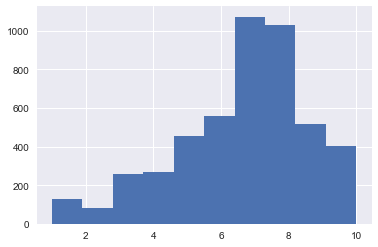

In [239]:
print(survey['JobSatisfaction'].mean())

plt.hist(survey['JobSatisfaction'])
plt.show()

In [240]:
# Making JobSatisfaction into binary
# This is necessary because JobSatisfaction is ordinal data
survey['Satisfied'] = np.where(survey['JobSatisfaction']>7, 1, 0)

# Dealing with multiple currencies in Compensation Amount
currencies = pd.read_csv('conversionRates.csv')

#Keep only useful variables
currencies = currencies[['originCountry', 'exchangeRate']]

#Left join to match CompensationCurrency and exchangeRates
survey = pd.merge(survey, currencies, how='left',
                  left_on='CompensationCurrency',
                  right_on='originCountry')


In [241]:
# Convert to all compensation to USD
survey['IncomeUSD'] = survey['CompensationAmount']*survey['exchangeRate']

print(survey.IncomeUSD.isnull().sum())

# One NaN to remove
survey.dropna(inplace=True)

1


In [242]:
survey.head()

,JobSatisfaction,Age,LearningCategorySelftTaught,LearningCategoryOnlineCourses,LearningCategoryWork,LearningCategoryUniversity,LearningCategoryKaggle,LearningCategoryOther,TimeGatheringData,TimeModelBuilding,TimeProduction,TimeVisualizing,TimeFindingInsights,TimeOtherSelect,CompensationAmount,CompensationCurrency,Satisfied,originCountry,exchangeRate,IncomeUSD
0,10.0,56.0,30.0,0.0,40.0,30.0,0.0,0.0,50.0,20.0,0.0,10.0,20.0,0.0,250000.0,USD,1,USD,1.000000,250000.0
1,7.0,43.0,70.0,0.0,30.0,0.0,0.0,0.0,60.0,10.0,5.0,15.0,10.0,0.0,80000.0,AUD,0,AUD,0.802310,64184.8
2,7.0,33.0,10.0,70.0,15.0,0.0,5.0,0.0,40.0,30.0,15.0,10.0,5.0,0.0,1200000.0,RUB,0,RUB,0.017402,20882.4
3,7.0,27.0,10.0,0.0,30.0,40.0,0.0,20.0,30.0,20.0,10.0,10.0,30.0,0.0,95000.0,INR,0,INR,0.015620,1483.9
4,5.0,26.0,50.0,50.0,0.0,0.0,0.0,0.0,35.0,20.0,25.0,10.0,10.0,0.0,1100000.0,TWD,0,TWD,0.033304,36634.4


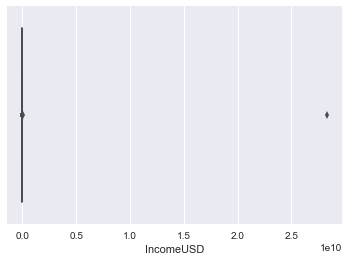

In [243]:
sns.boxplot(survey.IncomeUSD)
plt.show()

In [244]:
# Three outliers to remove, one clearly a mistake and two of compensation >USD2.5m
incomeoutlier = survey.IncomeUSD.max()
survey = survey.loc[survey['IncomeUSD'] != incomeoutlier, :]
incomeoutlier = survey.IncomeUSD.max()
survey = survey.loc[survey['IncomeUSD'] != incomeoutlier, :]
incomeoutlier = survey.IncomeUSD.max()
survey = survey.loc[survey['IncomeUSD'] != incomeoutlier, :]

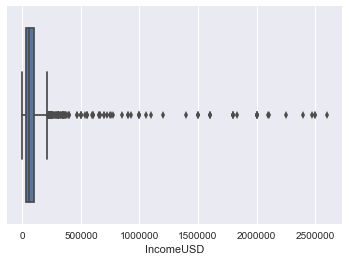

In [245]:
sns.boxplot(survey.IncomeUSD)
plt.show()

In [246]:
# Final step, train and test set
# Drop varialbes not useful for OLS and KNN
# Drop LearningCategoryOther and TimeOtherSelect - variables used to sum time to 100
X = survey.drop(['originCountry', 'JobSatisfaction', 'CompensationCurrency',
                 'exchangeRate','Satisfied', 'LearningCategoryOther',
                 'TimeOtherSelect', 'CompensationAmount'], axis=1)
y = survey[['Satisfied']]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)

## OLS

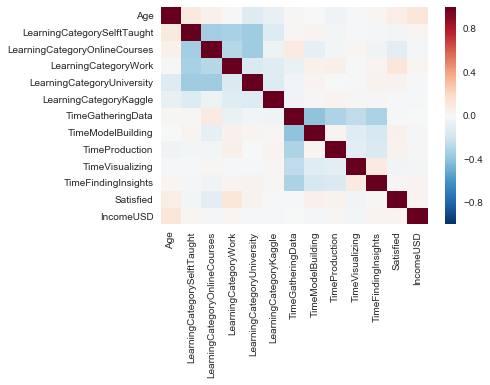

In [248]:
corr = survey.drop(['originCountry', 'JobSatisfaction', 'CompensationCurrency',
                    'LearningCategoryOther',
                    'TimeOtherSelect', 'exchangeRate', 'CompensationAmount'], axis=1).corr()

sns.heatmap(corr)
plt.show()

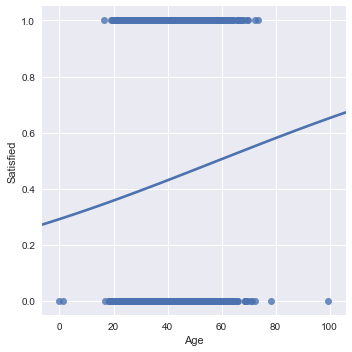

In [249]:
sns.lmplot(x='Age', y='Satisfied', data=survey, ci=False, logistic=True, x_jitter=True)
plt.show()

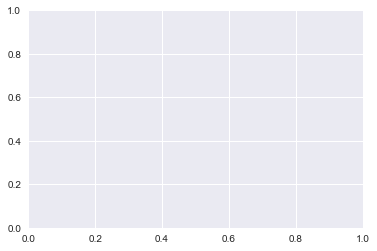

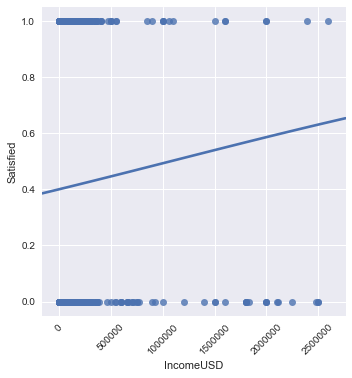

In [250]:
fig, ax = plt.subplots()
sns.lmplot(x='IncomeUSD', y='Satisfied', data=survey, ci=False, logistic=True, x_jitter=True)
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation=45)
plt.show()

In [253]:
# OLS

from sklearn import linear_model

#X_train
ls = linear_model.LogisticRegression()
ls.fit(X_train,y_train)
r2 = ls.score(X_train, y_train)
coef = ls.get_params()
print(coef, '\n')
print("R2 is:", r2)

#X_test
r2_test = ls.score(X_test, y_test)
y_hat = ls.predict(X_test)
print("R2 on test set:", r2_test)

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False} 

R2 is: 0.601118881119
R2 on test set: 0.601510067114


C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [312]:
ycounts = y.Satisfied.value_counts()
print(ycounts[0]/ycounts.sum())

0.591357247745


So while the model has a much higher R2 than I expected it would have (there are lots of factors missing that are likely to be important to explain job satisfaction), it does only marginally better in predicting than assuming all people are unsatisfied (in which case you'll be right 59% of the time).

## KNN

In [260]:
# Normalise the distance
from scipy.stats import zscore

X_z = X.apply(zscore)

#Split on X_z (have to split first then split - so OLS vs KNN comparison won't have same splits)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_z, y)

In [288]:
from sklearn import neighbors
from sklearn import metrics

knn = neighbors.KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train,y_train)
r2_knn = knn.score(X_train, y_train)

#Test
r2_knn_test = knn.score(X_test, y_test)
print("R2 of training model:", r2_knn)
print("R2 of test model:", r2_knn_test)

R2 of training model: 0.230679470069
R2 of test model: -0.16542315814


Okay, that's bad. But let's try *classifying* instead

In [309]:
knn = neighbors.KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train,y_train)
r2_knn = knn.score(X_train, y_train)

#Test
pred = knn.predict(X_test)
r2_knn_test = knn.score(X_test, y_test)
print("R2 of training model:", r2_knn)
print("R2 of test model:", r2_knn_test)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


R2 of training model: 0.663776223776
R2 of test model: 0.568791946309


This is an improvement, but it's still less accurate than always guessing 'not satisfied'. Maybe a better chosen k can help...

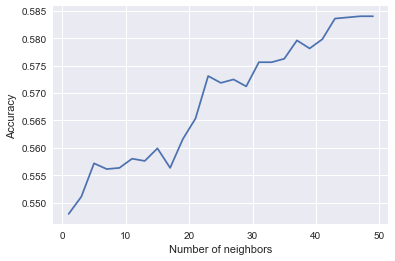

In [308]:
from sklearn import model_selection

# creating odd list of K for KNN
neighbornumber = list(range(1,51,2))

# empty list that will hold cv scores
cv_scores = []

# Getting y into right dimension (n,)
y_series = y.Satisfied

# perform 10-fold cross validation
for k in neighbornumber:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    scores = model_selection.cross_val_score(knn, X, y_series, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

plt.plot(neighbornumber, cv_scores)
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')

## Conclusion

So the kNN regression model does substantially worse than the OLS model. I'm not sure why the kNN model performs so poorly (it performs poorly even when changing n and adding weights). However, the kNN classifier has a similar accuracy to OLS, particularly using higher values of k. Neither of the models are particularly useful as predictors - they don't explain more than a simple model predicting any new observation as 'not satisfied'. 

From an *a priori* standpoint, the OLS here should perform reasonably well. It also allows one to investigate individual relationships between the feature and outcome (size and sign). Given that it is also a simpler model and easier to interpret this is the best model. However, it is still likely to have some bias:
- There is some multicollinearity between the time spent variables (as they sum to 100) and also among skills learnt (also sum to 100). Dropping the 'other' categories here should help reduce some of the multicollinearity.
- There is also likely to be omitted variable bias (there is a lot going into the error term include overall happiness - which also influences income and job satisfaction).
